In [10]:
import pandas as pd
import numpy as np 
import yfinance as yf
import datetime

start = '2010-01-01'
end = '2023-03-01'

gold_stock = yf.download('GC=F', start=start, end=end, interval='1d', auto_adjust=True)
gold_stock.to_csv('gold_stock_data.csv')

[*********************100%***********************]  1 of 1 completed


In [11]:
gold_stock = pd.read_csv('gold_stock_data.csv')

In [12]:
#Only need two colums
gold_stock = gold_stock[["Date","Close"]]
gold_stock

,Date,Close
0,2010-01-04,1117.699951
1,2010-01-05,1118.099976
2,2010-01-06,1135.900024
3,2010-01-07,1133.099976
4,2010-01-08,1138.199951
...,...,...
3305,2023-02-22,1832.000000
3306,2023-02-23,1818.000000
3307,2023-02-24,1808.800049
3308,2023-02-27,1817.000000


In [13]:
#The date column needs to be changed to type date, is currently type string
gold_stock['Date'] = pd.to_datetime(gold_stock['Date'])

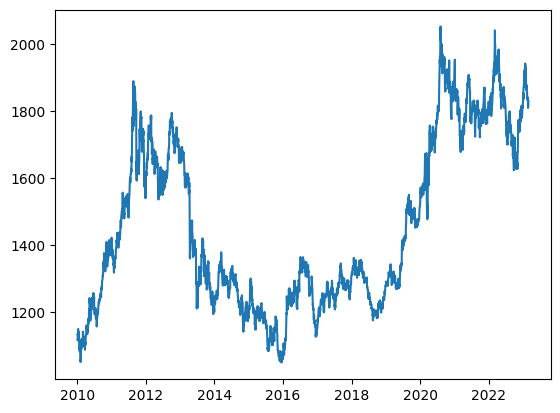

In [14]:
#lets plot the data to see how it looks 

import matplotlib.pyplot as plt

plt.plot(gold_stock['Date'], gold_stock['Close'])
plt.show()

In [15]:
#to use this data in the LSTM we need to make a new DF that shows the date and the close price and the last n prices. This is our window.
gold_stock['Target-3'] = gold_stock['Close'].shift(3)
gold_stock['Target-2'] = gold_stock['Close'].shift(2)
gold_stock['Target-1'] = gold_stock['Close'].shift(1)
gold_stock.rename(columns={'Close':'Target'}, inplace=True)

#Drop first 3 rows as they are missing target-n values
gold_stock.drop(index=gold_stock.index[:3],inplace=True)
gold_stock.reset_index(drop=True, inplace=True)
gold_stock
gold_stock.to_csv("transformed_data.csv")



In [7]:
def window_split_columns(df):
    #convert to numpy array
    df = df.to_numpy()

    dates = df[:,0]

    Y = df[:,1]

    X = df[:, 2:]
    X = X.reshape((len(dates), X.shape[1], 1))

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, Y = window_split_columns(gold_stock)

dates.shape, X.shape, Y.shape

((3307,), (3307, 3, 1), (3307,))

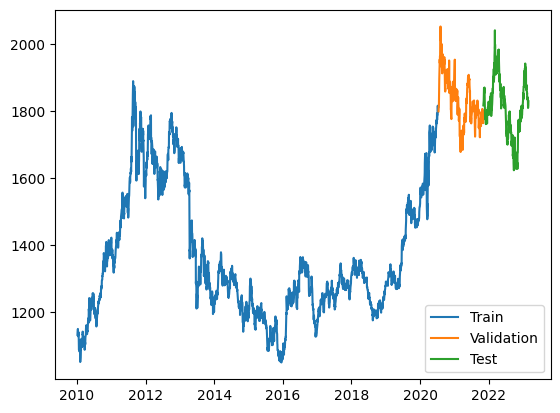

In [8]:
#Split data into train, val, test

percent80 = int(len(dates)*.8)
percent90 = int(len(dates)*.9)

dates_train, X_train, y_train = dates[:percent80], X[:percent80], Y[:percent80]
dates_val, X_val, y_val = dates[percent80:percent90], X[percent80:percent90], Y[percent80:percent90]
dates_test, X_test, y_test = dates[percent90:], X[percent90:], Y[percent90:]

#visualize the data split
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(["Train", "Validation", "Test"])

In [18]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(3,1)))
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=10)


Epoch 1/10
83/83 [==============================] - 2s 5ms/step - loss: 787219.0000 - mean_absolute_error: 705.7726
Epoch 2/10
83/83 [==============================] - 0s 3ms/step - loss: 963.6868 - mean_absolute_error: 21.6675
Epoch 3/10
83/83 [==============================] - 0s 3ms/step - loss: 352.2301 - mean_absolute_error: 13.0290
Epoch 4/10
83/83 [==============================] - 0s 3ms/step - loss: 352.6535 - mean_absolute_error: 13.0429
Epoch 5/10
83/83 [==============================] - 0s 3ms/step - loss: 355.5818 - mean_absolute_error: 13.1418
Epoch 6/10
83/83 [==============================] - 0s 3ms/step - loss: 354.5141 - mean_absolute_error: 13.0924
Epoch 7/10
83/83 [==============================] - 0s 3ms/step - loss: 354.2715 - mean_absolute_error: 13.1419
Epoch 8/10
83/83 [==============================] - 0s 3ms/step - loss: 356.6312 - mean_absolute_error: 13.1657
Epoch 9/10
83/83 [==============================] - 0s 3ms/step - loss: 358.4498 - mean_absolute_err

11/11 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Gold Price Predicitions')

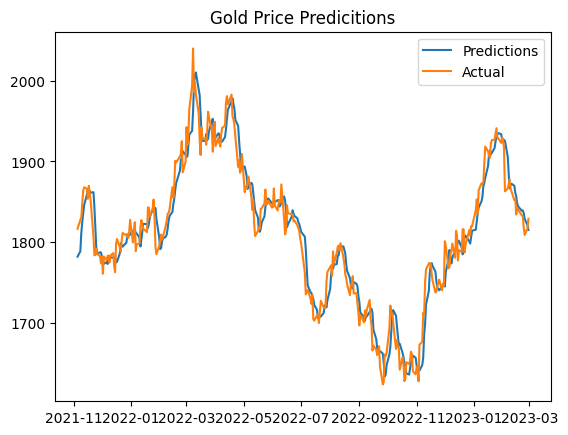

In [19]:
train_test = model.predict(X_test).flatten()

plt.plot(dates_test, train_test)
plt.plot(dates_test, y_test)

plt.legend(['Predictions', 'Actual'])
plt.title('Gold Price Predicitions')


In [20]:

n = len(dates_test)

predict1 = np.array(model.predict([X_test[0:1]]))
test1 = np.insert(X_test[0:1,1:3],2,[predict1[0]], axis=1)
predict2 = np.array(model.predict([test1]))
test2 = np.insert(test1[0:1, 1:3],2,[predict2[0]], axis=1)
predict3 = np.array(model.predict(test2))
test3 = np.insert(test2[0:1, 1:3],2,[predict3[0]], axis=1)
predict4 = np.array(model.predict(test3))


predictions = np.array([])
predictions = np.insert(predictions, 0, predict1)
predictions = np.insert(predictions, 1, predict2)
predictions = np.insert(predictions, 2, predict3)
predictions = np.insert(predictions, 3, predict4)
print(predictions,
y_test[1:4])

1/1 [==============================] - 0s 26ms/step
[1781.84606934 1778.77355957 1785.5501709  1782.13659668] [1827.4 1830.2 1847.6]
